# Yu-Gi-Oh! Trading Card Game Analysis

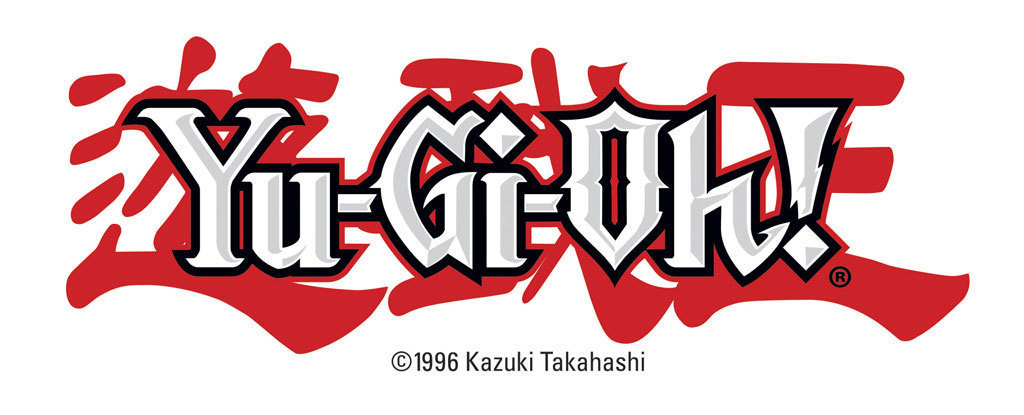

In [8]:
from IPython.display import Image, display
display(Image(filename="images/ygo_logo.jpg", width=500, height=300))

# Table of Contents

## Summary

The Yu-Gi-Oh! Trading Card Game (TCG) is a captivating, strategic duel card game that has enthralled players worldwide since its inception in Japan in 1999. Based on the fictional game of Duel Monsters created by manga artist Kazuki Takahashi, Yu-Gi-Oh! TCG involves two players facing off in a match where the objective is to reduce the opponent's life points to zero using a carefully assembled deck of cards. The game features a diverse array of cards, including Monsters, Spells, and Traps, each with unique abilities and strategies for use in battle. Players must skillfully navigate the complexities of deck building, anticipate their opponent's moves, and execute their strategies with precision to emerge victorious. Beyond its compelling gameplay, Yu-Gi-Oh! TCG boasts a rich lore, drawing from the narratives of the manga and anime series, making it not just a game but a journey into a meticulously crafted world of fantasy and competition. With its combination of deep strategic gameplay, an expansive universe of characters and cards, and a dedicated global community, Yu-Gi-Oh! TCG continues to be a beloved pastime and competitive endeavor for millions of fans around the world.

## Requirements & Configuration

In [98]:
import pymongo
import pprint as pp
import pandas as pd
import requests
import time
import base64
from IPython.display import display, Image
from PIL import Image as PILImage
import io
import base64
from datetime import datetime

In [10]:
# possible pandas option to set here
pd.set_option('display.max_rows', 500)

In [11]:
API_URL = "https://db.ygoprodeck.com/api/v7/cardinfo.php?misc=yes"
CNX_STR = "mongodb://localhost:27017"

Information: API rate limit is 20 requests per second

# ELT Process

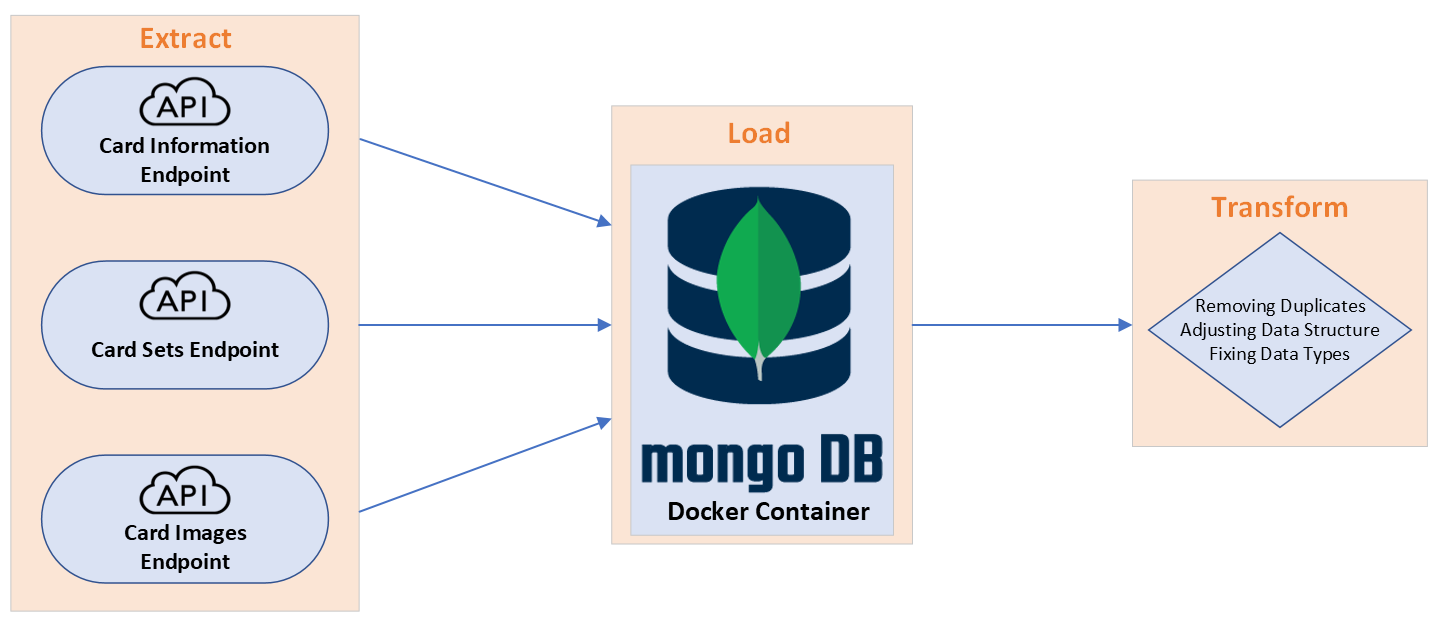

In [4]:
display(Image(filename="images/process_diagram.png", width=1000, height=400))

## DB Setup

In [59]:
# connect to the database
client = pymongo.MongoClient(CNX_STR)

# specify db and collections
db = client["ygo_cards"]
cards = db["card_info"]
images = db['card_images']
card_sets = db['card_sets']

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [60]:
db.list_collection_names()

['card_info', 'card_images', 'cards']

## Extract

In [104]:
# downloading all the cards from the API
r = requests.get(API_URL)
data = r.json()

In [105]:
# having a look at the first card
pp.pprint(data['data'][1])

{'archetype': 'Alien',
 'card_images': [{'id': 64163367,
                  'image_url': 'https://images.ygoprodeck.com/images/cards/64163367.jpg',
                  'image_url_cropped': 'https://images.ygoprodeck.com/images/cards_cropped/64163367.jpg',
                  'image_url_small': 'https://images.ygoprodeck.com/images/cards_small/64163367.jpg'}],
 'card_prices': [{'amazon_price': '0.50',
                  'cardmarket_price': '0.04',
                  'coolstuffinc_price': '0.25',
                  'ebay_price': '1.25',
                  'tcgplayer_price': '0.20'}],
 'card_sets': [{'set_code': 'GLAS-EN062',
                'set_name': "Gladiator's Assault",
                'set_price': '0',
                'set_rarity': 'Common',
                'set_rarity_code': '(C)'}],
 'desc': 'Each time an A-Counter(s) is removed from play by a card effect, '
         'place 1 A-Counter on this card. When this card is destroyed, '
         'distribute the A-Counters on this card among face

### Fetching all the card images

The API provides a URL to the image of each card, we can download the images and store them in the database as base64 encoded strings.
A card can have multiple images, in the case of multiple images we will only store the first image, since the images take up a considerable amount of space.

In [31]:
# loop through all the cards and download the images
for card in data['data']:
    card_name = card['name']
    image_url = card['card_images'][0]['image_url']
    image_response = requests.get(image_url)
    
    # Encode the image to base64
    image_b64 = base64.b64encode(image_response.content)
    
    # Save the encoded image to MongoDB
    images.insert_one({
        'name': card_name,
        'image': image_b64
    })
    time.sleep(0.1) # delay to not exceed the rate limit

In [33]:
# check if the images are in the database
images.count_documents({})

13030

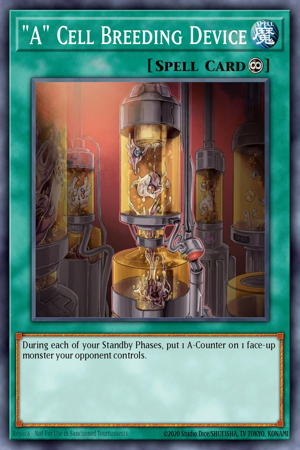

In [71]:
def display_resized_image(image_name=None, new_size=(300, 450)):
    if image_name is None:
        r = images.find_one()
    else:
        # Retrieve the image from the database
        r = images.find_one({"name": image_name})

    # Decode the base64-encoded image
    image_data = base64.b64decode(r['image'])

    # Convert the binary data to a PIL Image object
    image_new = PILImage.open(io.BytesIO(image_data))

    # Resize the image
    resized_image = image_new.resize(new_size)

    # Display the resized image
    display(resized_image)
    
# Display a resized image
display_resized_image()

## Load

In [21]:
%%capture
# we can easily insert the list containing all the data into the database
cards.insert_many(data['data'])

In [22]:
# check if the data is in the database
cards.count_documents({})

13030

In [23]:
# show random card
r = cards.aggregate([
    {"$sample": {"size": 1}}
])
pd.DataFrame(r)

,_id,id,name,type,frameType,desc,race,ygoprodeck_url,card_sets,card_images,card_prices,misc_info
0,660592ebef8a28605d75344a,82705573,Backfire,Trap Card,trap,If a face-up FIRE monster(s) you control is de...,Continuous,https://ygoprodeck.com/card/backfire-6951,"[{'set_name': 'Ancient Sanctuary', 'set_code':...","[{'id': 82705573, 'image_url': 'https://images...","[{'cardmarket_price': '0.07', 'tcgplayer_price...","[{'views': 59439, 'viewsweek': 130, 'upvotes':..."


In [56]:
# check the different types of card types
r = cards.aggregate([
    {"$group": {"_id": "$type"}},
    {"$sort": {"_id": 1}}
])
pd.DataFrame(r)

,_id
0,Effect Monster
1,Flip Effect Monster
2,Fusion Monster
3,Gemini Monster
4,Link Monster
5,Normal Monster
6,Normal Tuner Monster
7,Pendulum Effect Fusion Monster
8,Pendulum Effect Monster
9,Pendulum Effect Ritual Monster


In [57]:
# show a normal tuner monster
r = cards.aggregate([
    {"$match": {"type": "Link Monster"}},
    {"$sample": {"size": 1}}
])
pd.DataFrame(r)

,_id,id,name,type,frameType,desc,atk,race,attribute,linkval,linkmarkers,ygoprodeck_url,card_sets,card_images,card_prices,misc_info
0,65ff01609fa3b18d9e76aefa,79016563,Binary Sorceress,Link Monster,link,"2 monsters, except Tokens\r\nThis card gains t...",1600,Cyberse,EARTH,2,"[Left, Right]",https://ygoprodeck.com/card/binary-sorceress-8727,"[{'set_name': 'Structure Deck: Cyberse Link', ...","[{'id': 79016563, 'image_url': 'https://images...","[{'cardmarket_price': '0.07', 'tcgplayer_price...","[{'beta_name': 'Binal Sorceress', 'views': 796..."


In [24]:
# show a random card of each type
r = cards.aggregate([
    {"$group": {"_id": "$type", "card": {"$first": "$$ROOT"}}}
])
pd.DataFrame(r)

,_id,card
0,Effect Monster,"{'_id': 660592ebef8a28605d75311b, 'id': 869888..."
1,Union Effect Monster,"{'_id': 660592ebef8a28605d75312f, 'id': 300125..."
2,Trap Card,"{'_id': 660592ebef8a28605d753125, 'id': 681709..."
3,Synchro Monster,"{'_id': 660592ebef8a28605d753177, 'id': 309832..."
4,Normal Tuner Monster,"{'_id': 660592ebef8a28605d7531f5, 'id': 401555..."
5,Tuner Monster,"{'_id': 660592ebef8a28605d753189, 'id': 113026..."
6,Ritual Effect Monster,"{'_id': 660592ebef8a28605d75326f, 'id': 982875..."
7,Pendulum Effect Fusion Monster,"{'_id': 660592ebef8a28605d75336a, 'id': 506870..."
8,Token,"{'_id': 660592ebef8a28605d7532b5, 'id': 440520..."
9,Toon Monster,"{'_id': 660592ebef8a28605d75360a, 'id': 531836..."


### Additional Set Information

Using the cardsets endpoint from the API we can get additional valuable information about the sets the cards are in, such as the release date and the number of cards in the set.

In [61]:
# get dates for the sets
r = requests.get("https://db.ygoprodeck.com/api/v7/cardsets.php")
data = r.json()

data[0]

{'set_name': '2-Player Starter Deck: Yuya & Declan',
 'set_code': 'YS15',
 'num_of_cards': 42,
 'tcg_date': '2015-05-28',
 'set_image': 'https://images.ygoprodeck.com/images/sets/YS15.jpg'}

In [ ]:
%%capture
# insert additional set information into the database
card_sets.insert_many(data)

In [68]:
card_sets.find_one()

{'_id': ObjectId('66069f9eef8a28605d7596df'),
 'set_name': '2-Player Starter Deck: Yuya & Declan',
 'set_code': 'YS15',
 'num_of_cards': 42,
 'tcg_date': '2015-05-28',
 'set_image': 'https://images.ygoprodeck.com/images/sets/YS15.jpg'}

In [66]:
r = card_sets.aggregate([
    {"$project": {"_id": 0}},
    {"$limit": 5},
])
pd.DataFrame(r)

,set_name,set_code,num_of_cards,tcg_date,set_image
0,2-Player Starter Deck: Yuya & Declan,YS15,42,2015-05-28,https://images.ygoprodeck.com/images/sets/YS15...
1,2-Player Starter Set,STAX,88,2024-01-26,NaN
2,2013 Collectible Tins Wave 1,CT10,9,2013-08-30,https://images.ygoprodeck.com/images/sets/CT10...
3,2013 Collectible Tins Wave 2,CT10,9,2013-11-22,https://images.ygoprodeck.com/images/sets/CT10...
4,2014 Mega-Tin Mega Pack,MP14,247,2014-08-28,https://images.ygoprodeck.com/images/sets/MP14...


## Transform
- check all the datatypes in the collections (change date data type from set collection)

Converting the date in the card_sets collection to a proper date object results in an error, this is due to the fact that some of the dates are not in the correct format. Let us first check how many dates are not in the correct format.

In [73]:
pd.DataFrame(card_sets.find({"tcg_date": "0000-00-00"}))

,_id,set_name,set_code,num_of_cards,tcg_date,set_image,release_date
0,65ff139d9fa3b18d9e76e133,Yu-Gi-Oh! Championship Series 2023 prize card,YCSW,1,0000-00-00,https://images.ygoprodeck.com/images/sets/YCSW...,None


We can see that there is 1 card that has a wrong date format, we therefore have to handle the date conversion differently and will treat this case with a missing value

In [94]:
%%capture
card_sets.update_many(
    {}, 
    [
        {"$set": {
            "tcg_date": {
                "$cond": {
                    "if": {"$ne": ["$tcg_date", "0000-00-00"]},  # Check if tcg_date is not '0000-00-00'
                    "then": {"$toDate": "$tcg_date"},  # If true, convert tcg_date to date
                    "else": None  # If false, set tcg_date to None or choose another placeholder
                }
            }
        }}
    ]
)

We also need to convert the tcg_date and ocg_date fields in the card collection to datetime objects. Due to these dates being stored in an array in a document, we need to choose a slightly different approach. We will iterate over each document in the collection, convert the dates to datetime objects, and update the document with the modified dates.  

In [99]:
# Iterate over each document in the collection
for card in cards.find():
    # Iterate over each item in the misc_info array (if it exists)
    for misc in card.get("misc_info", []):
        # Convert tcg_date and ocg_date to datetime objects
        if 'tcg_date' in misc:
            misc['tcg_date'] = datetime.strptime(misc['tcg_date'], "%Y-%m-%d")
        if 'ocg_date' in misc:
            misc['ocg_date'] = datetime.strptime(misc['ocg_date'], "%Y-%m-%d")
    
    # Update the document with the modified misc_info array
    cards.update_one(
        {"_id": card["_id"]},
        {"$set": {"misc_info": card["misc_info"]}}
    )

Now we also need to convert the numbers in the card_prices array of the card collection to float values. We will iterate over each document in the collection, convert the prices to float values, and update the document with the modified prices.

In [100]:
# Iterate over each document in the collection
for card in cards.find():
    # Check if card_prices exists and is not empty
    if 'card_prices' in card and card['card_prices']:
        # Convert each price to float
        for price_info in card['card_prices']:
            price_info['cardmarket_price'] = float(price_info['cardmarket_price'])
            price_info['tcgplayer_price'] = float(price_info['tcgplayer_price'])
            price_info['ebay_price'] = float(price_info['ebay_price'])
            price_info['amazon_price'] = float(price_info['amazon_price'])
            price_info['coolstuffinc_price'] = float(price_info['coolstuffinc_price'])

        # Update the document with the modified card_prices array
        cards.update_one(
            {"_id": card["_id"]},
            {"$set": {"card_prices": card['card_prices']}}
        )

The set_price field in the card_sets array of the cards collection is also stored as a string, we can convert this to a float value.

In [102]:
# Iterate over each document in the collection
for card in cards.find():
    # Check if card_sets exists and is not empty
    if 'card_sets' in card and card['card_sets']:
        # Convert set_price to float
        for set_info in card['card_sets']:
            set_info['set_price'] = float(set_info['set_price'])

        # Update the document with the modified card_sets array
        cards.update_one(
            {"_id": card["_id"]},
            {"$set": {"card_sets": card['card_sets']}}
        )

### Check for duplicates

In [49]:
# check if there are any duplicate ids
cards.count_documents({}) == cards.count_documents({"id": {"$exists": True}})

True

In [50]:
# check if there are any duplicate names
cards.count_documents({}) == cards.count_documents({"name": {"$exists": True}})

True

In [6]:
r = cards.aggregate([
    {"$project": {"_id": 0}},
    {"$limit": 5},
])
pd.DataFrame(r)

,id,name,type,frameType,desc,race,ygoprodeck_url,card_sets,card_images,card_prices,atk,def,level,attribute,archetype
0,86198326,7 Completed,Spell Card,spell,Activate this card by choosing ATK or DEF; equ...,Equip,https://ygoprodeck.com/card/7-completed-7222,"[{'set_name': 'Battle Pack 3: Monster League',...","[{'id': 86198326, 'image_url': 'https://images...","[{'cardmarket_price': '0.23', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN
1,1561110,ABC-Dragon Buster,Fusion Monster,fusion,"""A-Assault Core"" + ""B-Buster Drake"" + ""C-Crush...",Machine,https://ygoprodeck.com/card/abc-dragon-buster-137,[{'set_name': 'Legendary Collection Kaiba Mega...,"[{'id': 1561110, 'image_url': 'https://images....","[{'cardmarket_price': '0.28', 'tcgplayer_price...",3000.0,2800.0,8.0,LIGHT,ABC
2,34541863,"""A"" Cell Breeding Device",Spell Card,spell,"During each of your Standby Phases, put 1 A-Co...",Continuous,https://ygoprodeck.com/card/a-cell-breeding-de...,"[{'set_name': 'Force of the Breaker', 'set_cod...","[{'id': 34541863, 'image_url': 'https://images...","[{'cardmarket_price': '0.10', 'tcgplayer_price...",NaN,NaN,NaN,NaN,Alien
3,32207100,A Major Upset,Trap Card,trap,Tribute 1 face-up Attack Position Level 2 or l...,Normal,https://ygoprodeck.com/card/a-major-upset-2734,"[{'set_name': 'Ancient Prophecy', 'set_code': ...","[{'id': 32207100, 'image_url': 'https://images...","[{'cardmarket_price': '0.07', 'tcgplayer_price...",NaN,NaN,NaN,NaN,NaN
4,10493654,A.I. Contact,Spell Card,spell,"If ""Ignister A.I.Land"" is in your Field Zone: ...",Normal,https://ygoprodeck.com/card/a-i-contact-10726,"[{'set_name': '2021 Tin of Ancient Battles', '...","[{'id': 10493654, 'image_url': 'https://images...","[{'cardmarket_price': '0.12', 'tcgplayer_price...",NaN,NaN,NaN,NaN,@Ignister


## Data Structure

Explain the data structure and the relationships between the collections

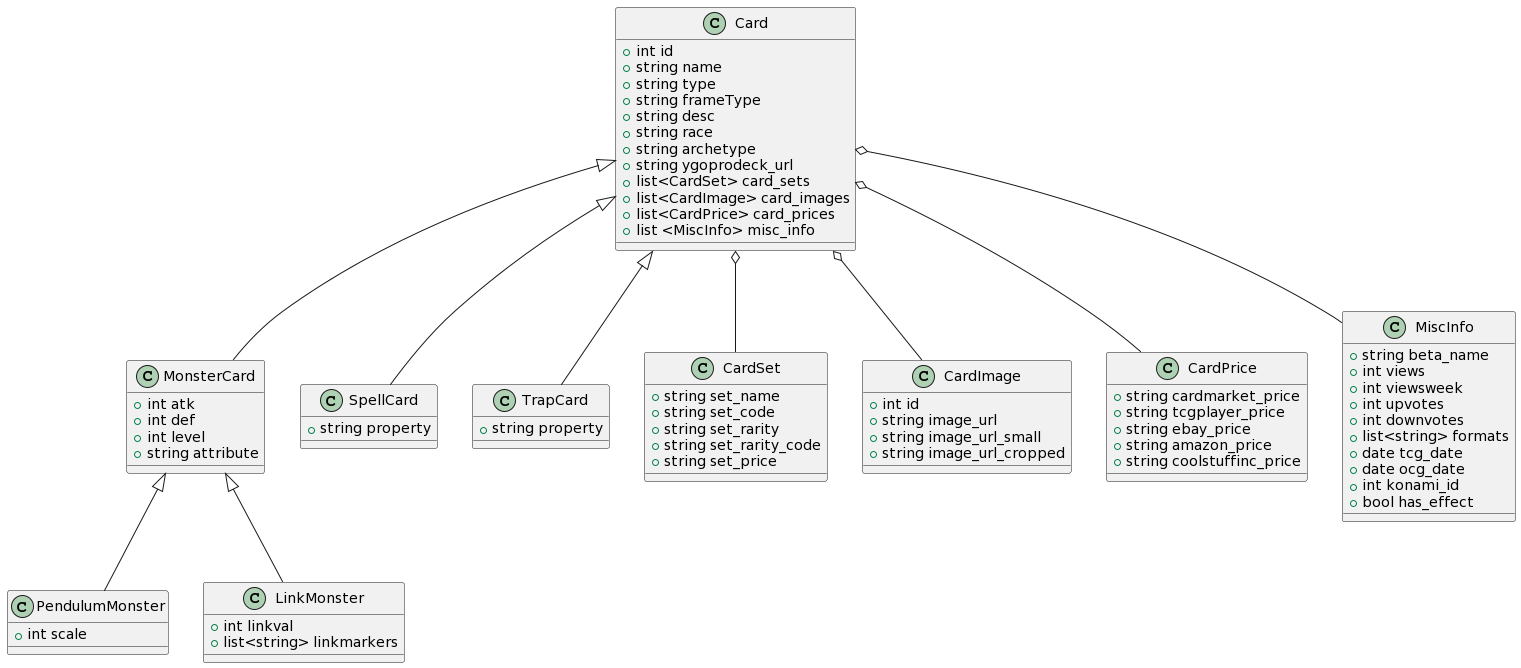

In [106]:
display(Image(filename='images/card_diagram.png', width=200, height=100))

The downloaded images will be kept in a separate collection, since the images take up a large amount of space and are not needed for all queries.
We therefore have a simple card image class:

In [ ]:
display(Image(filename='images/card_image_diagram.png', width=200, height=100))

The additional card set information will also be kept in a separate collection, since embedding the information in the card collection would lead to a lot of redundant data. This will make querying the card data more efficient, but on the other hand we have to perform a lookup to get the additional set information.

In [ ]:
display(Image(filename='images/card_set_diagram.png', width=200, height=100))

# Data Analysis

Ideas for aggregation pipelines/analysis:
- Which card has the most re-printings? (occurs in the most sets)
- Which card has the most different versions? (e.g. normal, rare, ultra rare, etc.)
- Which are the most expensive cards? (e.g. top 10)
- Which are the most powerful cards? (ATK points) (e.g. top 10)
- Which set contains the most expensive cards? (make plot of multiple sets in one graph)
- Analyze rarity versions throughout the years (e.g. how many ultra rares in 2020 vs 2021)

## Which card has the most re-printings? (occurs in the most sets)
Throughout the years the same card can be re-printed in different sets, we can count the number of times a card occurs in different sets to determine which card has the most re-printings.

In [80]:
# most re-printings
r = cards.aggregate([
    {"$unwind": "$card_sets"},
    {"$group": {"_id": "$name", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
pd.DataFrame(r)

,_id,count
0,Blue-Eyes White Dragon,62
1,Mystical Space Typhoon,59
2,Dark Magician,53
3,Call of the Haunted,53
4,Cyber Dragon,45
5,Polymerization,41
6,Dark Hole,40
7,Swords of Revealing Light,39
8,Book of Moon,39
9,Reinforcement of the Army,38


The card "Blue-Eyes White Dragon" has the most re-printings with 62 different versions.
We can have a look at the card by printing the first version of the card.

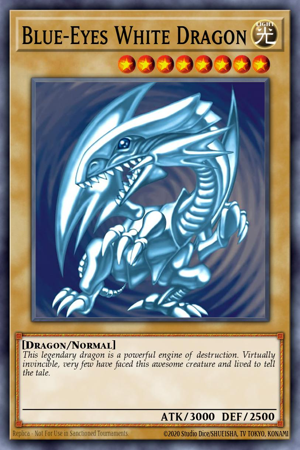

In [76]:
# display an image of the card
display_resized_image("Blue-Eyes White Dragon")

## Find the most expensive cards based on set prices
As we saw previously, a card can have multiple versions with different prices. We can determine the most expensive cards by looking at the highest set price for each card, that is the price of the card in the respective set.

In [95]:
from bson.objectid import ObjectId

# Define the aggregation pipeline
pipeline = [
    # Match the document by its unique ID or any other criteria
    {"$match": {"_id": ObjectId("65ff01609fa3b18d9e76afcd")}},
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    # Convert set_price from string to float (assuming all prices are valid floats)
    {"$addFields": {"card_sets.set_price": {"$convert": {"input": "$card_sets.set_price", "to": "double", "onError": 0}}}},
    # Sort by set_price in descending order to ensure the highest price is first
    {"$sort": {"card_sets.set_price": -1}},
    # Group by the original document ID, preserving the entire card set document that has the highest price
    {"$group": {
        "_id": "$_id",
        "max_price": {"$first": "$card_sets.set_price"},
        "card_set": {"$first": "$card_sets"}
    }}
]

# Execute the aggregation query
result = cards.aggregate(pipeline)
pd.DataFrame(result)

,_id,max_price,card_set
0,65ff01609fa3b18d9e76afcd,2999.98,"{'set_name': 'Retro Pack', 'set_code': 'RP01-E..."


We can extend this analysis to find the overall most expensive cards by looking at the highest set price for each card.

In [77]:
# Define the aggregation pipeline
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    # Convert set_price from string to float (assuming all prices are valid floats)
    {"$addFields": {"card_sets.set_price": {"$convert": {"input": "$card_sets.set_price", "to": "double", "onError": 0}}}},
    # Sort by set_price in descending order to ensure the highest price comes first
    {"$sort": {"card_sets.set_price": -1}},
    # Limit the results to 1 to get the top most expensive card set
    {"$limit": 10},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "card_id": "$id",
        "name": "$name",
        "set_name": "$card_sets.set_name",
        "set_code": "$card_sets.set_code",
        "set_rarity": "$card_sets.set_rarity",
        "set_price": "$card_sets.set_price"
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
pd.DataFrame(result)

,card_id,name,set_name,set_code,set_rarity,set_price
0,57728570,Crush Card Virus,Shonen Jump Championship 2007 Prize Card A,SJCS-EN004,Ultra Rare,115033.33
1,81059524,Des Volstgalph,Shonen Jump Championship 2005 Prize Card,SJC-EN002,Ultra Rare,95074.95
2,69015963,Cyber-Stein,Shonen Jump Championship 2004 Prize Card,SJC-EN001,Ultra Rare,24067.80
3,75500286,Gold Sarcophagus,Shonen Jump Championship 2007 Prize Card B,SJCS-EN005,Ultra Rare,24000.00
4,75500286,Gold Sarcophagus,Pharaoh Tour 2007 promotional cards,PT03-EN001,Ultra Rare,21127.30
5,85771019,Darklord Asmodeus,Yu-Gi-Oh! Championship Series 2010 Prize Cards,YCSW-EN001,Ultra Rare,20299.50
6,55713623,Shrink,Shonen Jump Championship 2006 Prize Card,SJC-EN003,Ultra Rare,18530.00
7,88643579,Dark End Dragon,Shonen Jump Championship 2009 Prize Card,SJCS-EN007,Ultra Rare,14693.33
8,54343893,Vice Dragon,Duel Disk - Yusei Version,DDY1-EN001,Ultra Rare,10001.09
9,63746411,Number 106: Giant Hand,Yu-Gi-Oh! Championship Series 2013 Prize Card,YCSW-EN006,Ultra Rare,8915.68


<Axes: title={'center': 'Top 10 Most Expensive Card Sets'}, xlabel='name'>

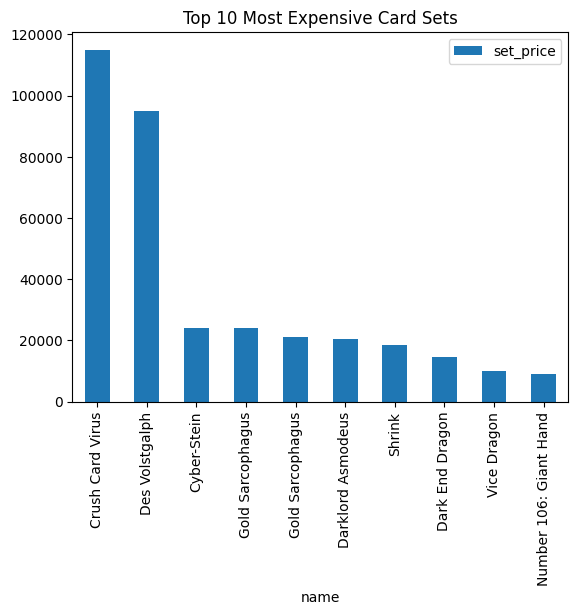

In [107]:
pd.DataFrame(result).plot(kind='bar', x='name', y='set_price', title='Top 10 Most Expensive Card Sets', ylabel='Set Price', xlabel='Card Name')

## Determine which set contains the most expensive cards
We can determine which set contains the most expensive cards by calculating the total price of all cards in each set and sorting the results in descending order.

In [81]:
# Define the aggregation pipeline
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    # Convert set_price from string to float (assuming all prices are valid floats)
    {"$addFields": {"card_sets.set_price": {"$convert": {"input": "$card_sets.set_price", "to": "double", "onError": 0}}}},
    # Group by set_name to calculate the total price of all cards in the set
    {"$group": {
        "_id": "$card_sets.set_name",
        "total_price": {"$sum": "$card_sets.set_price"}
    }},
    # Sort by total_price in descending order to ensure the highest price comes first
    {"$sort": {"total_price": -1}},
    # Limit the results to 10 to get the top most expensive card sets
    {"$limit": 10},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "set_name": "$_id",
        "total_price": 1
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
pd.DataFrame(result)

,total_price,set_name
0,115033.33,Shonen Jump Championship 2007 Prize Card A
1,95074.95,Shonen Jump Championship 2005 Prize Card
2,30547.47,Yu-Gi-Oh! Championship Series 2010 Prize Cards
3,25119.51,Retro Pack
4,24067.80,Shonen Jump Championship 2004 Prize Card
5,24000.00,Shonen Jump Championship 2007 Prize Card B
6,21151.04,Pharaoh Tour 2007 promotional cards
7,18530.00,Shonen Jump Championship 2006 Prize Card
8,14693.33,Shonen Jump Championship 2009 Prize Card
9,13047.42,Yu-Gi-Oh! Championship Series 2011 Prize Card


<Axes: title={'center': 'Top 10 Most Expensive Card Sets'}, xlabel='Set Name', ylabel='Total Price'>

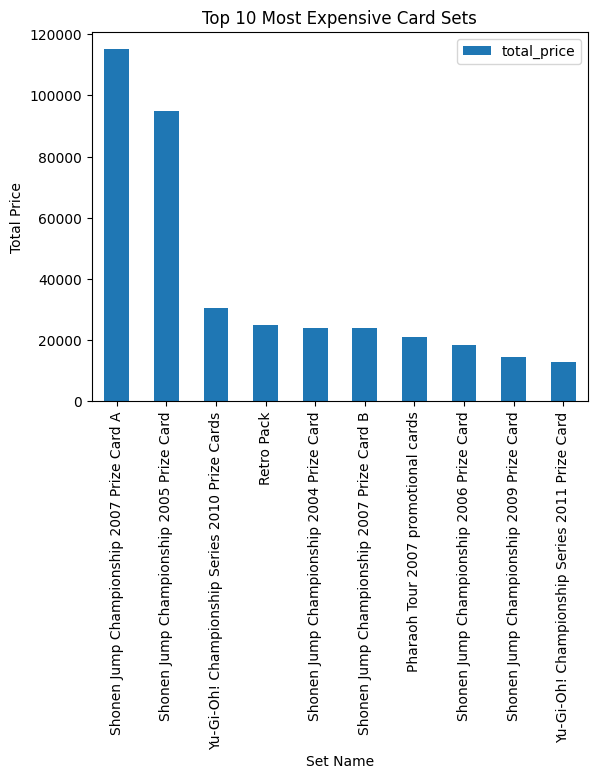

In [82]:
pd.DataFrame(result).plot(kind='bar', x='set_name', y='total_price', title='Top 10 Most Expensive Card Sets', ylabel='Total Price', xlabel='Set Name')

## Nr of rare cards per set over the years

In [110]:
# Define the aggregation pipeline
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    # Group by set_name and set_rarity to calculate the total number of rare cards in each set
    {"$group": {
        "_id": {"set_name": "$card_sets.set_name", "set_rarity": "$card_sets.set_rarity"},
        "total_rare_cards": {"$sum": 1}
    }},
    # Sort by set_name in ascending order to ensure the results are ordered by set name
    {"$sort": {"_id.set_name": 1}},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "set_name": "$_id.set_name",
        "set_rarity": "$_id.set_rarity",
        "total_rare_cards": 1
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
pd.DataFrame(result)

,total_rare_cards,set_name,set_rarity
0,38,2-Player Starter Deck: Yuya & Declan,Common
1,2,2-Player Starter Deck: Yuya & Declan,Super Rare
2,2,2-Player Starter Deck: Yuya & Declan,Ultra Rare
3,79,2-Player Starter Set,Common
4,8,2-Player Starter Set,Ultra Rare
...,...,...,...
2254,9,Zexal Collection Tin,Ultra Rare
2255,3,Zexal Collection Tin,Ultimate Rare
2256,12,Zexal Collection Tin,Super Rare
2257,36,Zombie World Structure Deck,Common


In [115]:
# join date information from card_sets collection
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    
    # Lookup to join date information from the second collection
    {"$lookup": {
        "from": "card_sets",  # Replace with the actual name of your second collection
        "localField": "card_sets.set_name",
        "foreignField": "set_name",
        "as": "set_details"
    }},
    
    # Unwind the result of the lookup to process each joined document
    {"$unwind": "$set_details"},
    
    # Group by set_name and set_rarity to calculate the total number of rare cards in each set
    {"$group": {
        "_id": {"set_name": "$card_sets.set_name", "set_rarity": "$card_sets.set_rarity", "tcg_date": "$set_details.tcg_date"},
        "total_rare_cards": {"$sum": 1}
    }},
    
    # Sort by set_name in ascending order to ensure the results are ordered by set name
    {"$sort": {"_id.set_name": 1}},
    
    # Project the results to format the output, now including the tcg_date
    {"$project": {
        "_id": 0,
        "set_name": "$_id.set_name",
        "set_rarity": "$_id.set_rarity",
        "tcg_date": "$_id.tcg_date",
        "total_rare_cards": 1
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
pd.DataFrame(result)

,total_rare_cards,set_name,set_rarity,tcg_date
0,2,2-Player Starter Deck: Yuya & Declan,Ultra Rare,2015-05-28
1,2,2-Player Starter Deck: Yuya & Declan,Super Rare,2015-05-28
2,38,2-Player Starter Deck: Yuya & Declan,Common,2015-05-28
3,79,2-Player Starter Set,Common,2024-01-26
4,8,2-Player Starter Set,Ultra Rare,2024-01-26
...,...,...,...,...
2252,12,Zexal Collection Tin,Super Rare,2013-03-07
2253,9,Zexal Collection Tin,Ultra Rare,2013-03-07
2254,3,Zexal Collection Tin,Ultimate Rare,2013-03-07
2255,1,Zombie World Structure Deck,Ultra Rare,2008-10-21


In [95]:
card_sets.find_one({"set_name": "Legend of Blue Eyes White Dragon"})

{'_id': ObjectId('66069f9eef8a28605d75983f'),
 'set_name': 'Legend of Blue Eyes White Dragon',
 'set_code': 'LOB',
 'num_of_cards': 355,
 'tcg_date': datetime.datetime(2002, 3, 8, 0, 0),
 'set_image': 'https://images.ygoprodeck.com/images/sets/LOB.jpg'}

## Count Cards by Type

In [107]:
# Define the aggregation pipeline
pipeline = [
    # Group by card type to calculate the total number of cards of each type
    {"$group": {
        "_id": "$type",
        "total_cards": {"$sum": 1}
    }},
    # Sort by total_cards in descending order to ensure the highest count comes first
    {"$sort": {"total_cards": -1}},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "card_type": "$_id",
        "total_cards": 1
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
pd.DataFrame(result)

,total_cards,card_type
0,4648,Effect Monster
1,2539,Spell Card
2,1899,Trap Card
3,661,Normal Monster
4,507,XYZ Monster
5,457,Fusion Monster
6,453,Tuner Monster
7,419,Synchro Monster
8,401,Link Monster
9,267,Pendulum Effect Monster


## Average Card Prices by Rarity within a Set

In [149]:
# Define the aggregation pipeline
pipeline = [
    {"$unwind": "$card_sets"},
    {"$group": {
        "_id": {
            "set_name": "$card_sets.set_name",
            "set_rarity": "$card_sets.set_rarity"
        },
        "averageSetPrice": {"$avg": "$card_sets.set_price"}
    }},
    {"$sort": {"_id.set_name": 1, "averageSetPrice": -1}}
]

result = cards.aggregate(pipeline)
pd.DataFrame(result)

,_id,averageSetPrice
0,{'set_name': '2-Player Starter Deck: Yuya & De...,11.920000
1,{'set_name': '2-Player Starter Deck: Yuya & De...,4.801842
2,{'set_name': '2-Player Starter Deck: Yuya & De...,4.510000
3,"{'set_name': '2-Player Starter Set', 'set_rari...",0.000000
4,"{'set_name': '2-Player Starter Set', 'set_rari...",0.000000
...,...,...
2254,"{'set_name': 'Zexal Collection Tin', 'set_rari...",5.830000
2255,"{'set_name': 'Zexal Collection Tin', 'set_rari...",3.523333
2256,"{'set_name': 'Zexal Collection Tin', 'set_rari...",1.495833
2257,"{'set_name': 'Zombie World Structure Deck', 's...",0.000000


## Most trending cards

The number of times a card has been viewed in the database this week (does not include API/external views)

In [128]:
# Define the aggregation pipeline
pipeline = [
    { "$unwind": "$misc_info" },
    { "$sort": { "misc_info.viewsweek": -1 } },
    { "$limit": 10 },
    { "$project": { "name": 1, "viewsweek": "$misc_info.viewsweek" } }
]

result = cards.aggregate(pipeline)
df = pd.DataFrame(result)
df

,_id,name,viewsweek
0,660592ebef8a28605d7533d7,Ash Blossom & Joyous Spring,26338
1,660592ebef8a28605d75479e,Infinite Impermanence,19062
2,660592ebef8a28605d754f8f,"Nibiru, the Primal Being",11518
3,660592ebef8a28605d753e8f,Effect Veiler,11232
4,660592ebef8a28605d755f64,Triple Tactics Talent,10764
5,660592ebef8a28605d753726,Called by the Grave,9412
6,660592ebef8a28605d753e07,Droll & Lock Bird,9361
7,660592ebef8a28605d7556ae,S:P Little Knight,8112
8,660592ebef8a28605d755316,Pot of Prosperity,7852
9,660592ebef8a28605d755b84,Super Starslayer TY-PHON - Sky Crisis,6944


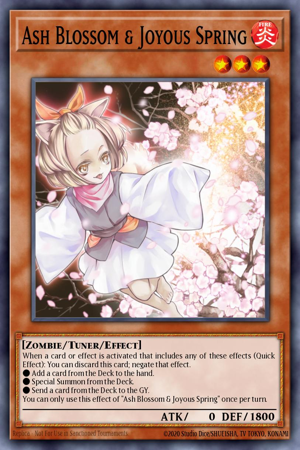

In [129]:
# have a look at the most viewed card this week
display_resized_image(df.iloc[0]['name'])

## Cards by Release Date
Find out how many cards were released per year, giving insights into the game's expansion over time.

In [142]:
pipeline = [
    { "$unwind": "$misc_info" },
    { "$group": { 
        "_id": { "$substr": ["$misc_info.tcg_date", 0, 4] }, 
        "count": { "$sum": 1 } 
    }},
    { "$sort": { "_id": 1 } }
]

result = cards.aggregate(pipeline)
pd.DataFrame(result)

,_id,count
0,,417
1,2001,1
2,2002,609
3,2003,551
4,2004,397
5,2005,289
6,2006,329
7,2007,414
8,2008,490
9,2009,475


## Distribution of Cards by Archetype
Find out how many cards belong to each archetype, giving insights into the variety and potential deck strategies.

In [144]:
pipeline = [
    { "$match": { "archetype": { "$exists": True } } },
    { "$group": { "_id": "$archetype", "count": { "$sum": 1 } } },
    { "$sort": { "count": -1 } }
]

result = cards.aggregate(pipeline)
pd.DataFrame(result)

,_id,count
0,Elemental HERO,133
1,Performapal,90
2,Archfiend,88
3,Blackwing,81
4,D/D,65
...,...,...
532,Divine Dragon,1
533,Sky Scourge,1
534,Diabellstar,1
535,Mokey Mokey,1


# Conclusions

# Learnings

In [8]:
%%HTML
<style>
/* display:none  -> hide In/Out column */
/* display:block -> show In/Out column */
div.prompt {display:none}
h1#Table-of-Contents {display:none}
</style>